# Prediction Focused Analysis With Canonical Functional Component Analysis: An Application To A Libyan Reservoir

Author: Lewis Li 

Date: May 6th 2016


In this notebook, we will demonstrate the application of Prediction Focused Analysis on an analog to Winstershall's Concession C97-I, which is located in the N-97 field in the Western Hameimat Trough of the Sirte basin of north-central Libya. The reservoir is thus comprised of 5 distinct compartments resulting in 4 uncertain fault transmissibilities. A large aquifer is located in the lowest compartment, but the depth of this oil water contact also remains uncertain. Other uncertain reservoir parameters are relative permeabilites for the oil and water phases and oil viscosity.

<img src="../../figures/FieldOverview.png" width="480">

We consider the situation where 5 producers and 3 injectors have already been drilled at the locations depicted in Figure 5. The field has been in production for 3500 days, and production data is available for all 5 wells. A decision needs to be made regarding the economic feasibility drilling of a 6th producer in the smallest reservoir compartment (denoted PNEW in Figure 5). Specifically, this decision will be made based on the forecasted performance of this new well over the next 4000 days. Therefore, we will seek to estimate the P10-P50-P90 forecasts of PNEW based on the first 10 years of production data from the existing 5 producers. 


A prior set of models is required for CFCA to establish a statistical relationship between the data and forecast. In this case, a set of 500 prior models are generated by applying Monte Carlo. The prior models were forward modelled using a streamline simulator (3DSL) over all 7500 days, to encompass both the 3500 days of production data, as well as the 4000 days of forecast required to make the decision regarding the new well.


In [1]:
addpath('../cfca');
addpath('../util');
addpath('../../thirdparty/fda_matlab');
load('../../data/PriorRuns/Prior.mat');

We need to specify which data we will use as forecast, and which we will use as historical data.

In [2]:
% We call everything before this time step the 'observed' data (Corresponds to 3500 days)
HistoricalEnd = 65;

% We call everything after this step the 'forecast'
ForecastStart = 125;

% Total number of days simulated in 3DSL
TotalDaysSimulated=11500;

% Total number of time steps
TotalNumTimeSteps = 200;

% The column in the Data struct that refers to the attribute we want to use
% as the forecast/historical
ForecastColumn = 4;   % Oil Rate
HistoricalColumn = 4; % Oil Rate
TimeColumn = 2;       % Simulation Time

% Object on which forecasting is required (New well to be drilled)
ForecastObjectName = {'PNEW2'};

% Existing wells whose production rates are used as historical data
HistoricalObjectName = {'P1','P2','P3','P4','P5'};

% Generates data structure which will be used later for CFCA
[HistoricalStruct,ForecastStruct] = GenerateDataStructsWithInterpolation(Data,...
    PropertyNames,ForecastColumn,HistoricalColumn,TimeColumn,HistoricalEnd,...
    ForecastStart,TotalNumTimeSteps,[6 20],[6 20],ForecastObjectName,...
    HistoricalObjectName,TotalDaysSimulated);
    


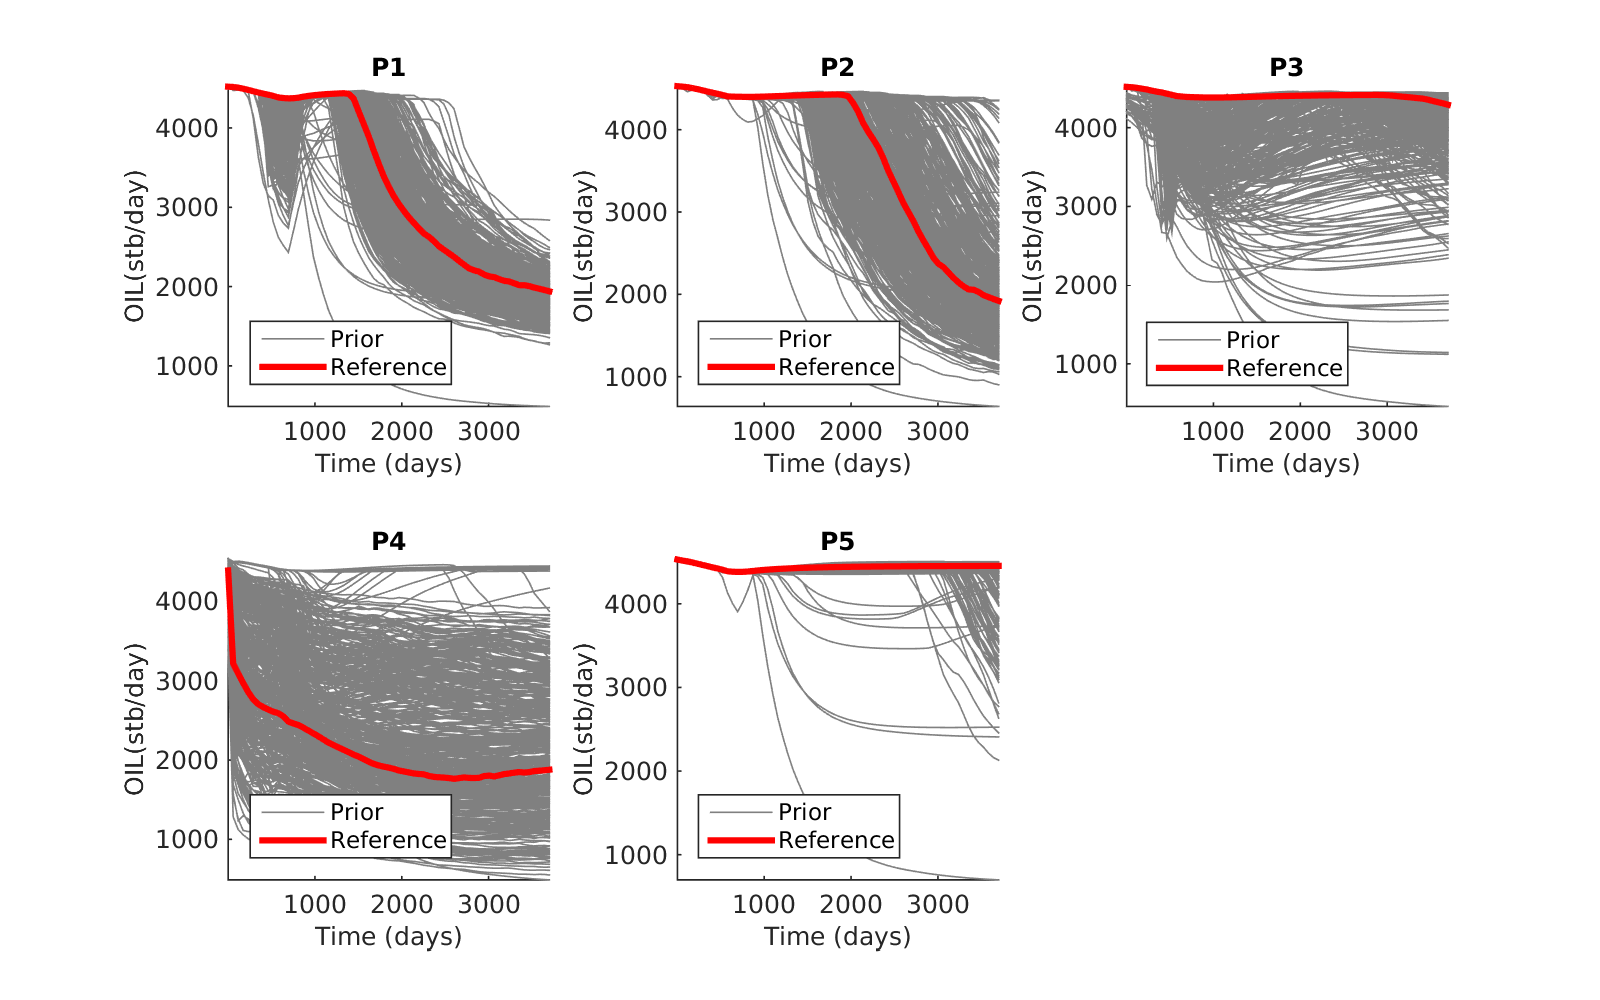

In [3]:
%plot inline -s 1600,1000

% Set aside one realization that we will deem the "reference";
TruthRealization = 150;
FontSize = 24;

PlotInputResponse( HistoricalStruct,TruthRealization,FontSize);


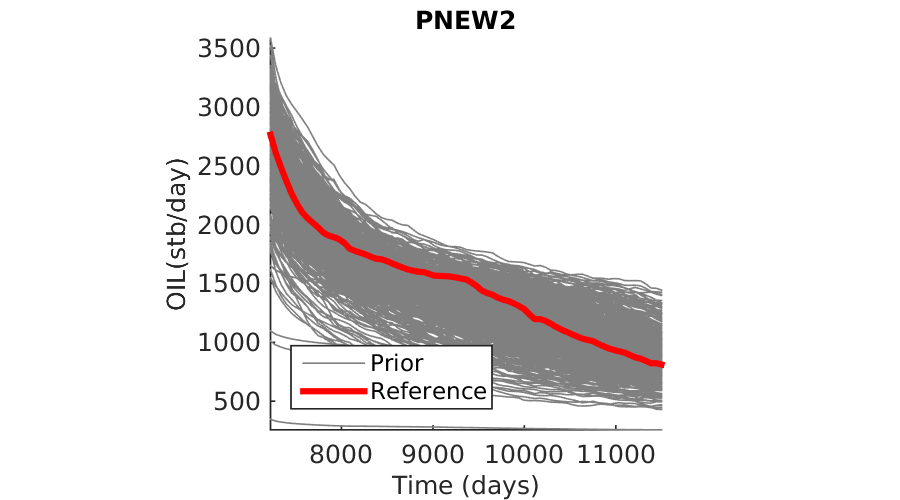

In [4]:
%plot inline -s 900,500
FontSize = 24;
PlotInputResponse( ForecastStruct,TruthRealization,FontSize);

This is a trial-error process, where you will pick the order and number
of knots to use as the splines. Generally the longer the time forecast,
the more knots will be required. The best way to do this is to pick some
splines, and graphically view the resulting fit for some randomly selected
realizations. This is implemented in ComputeHarmonicScores

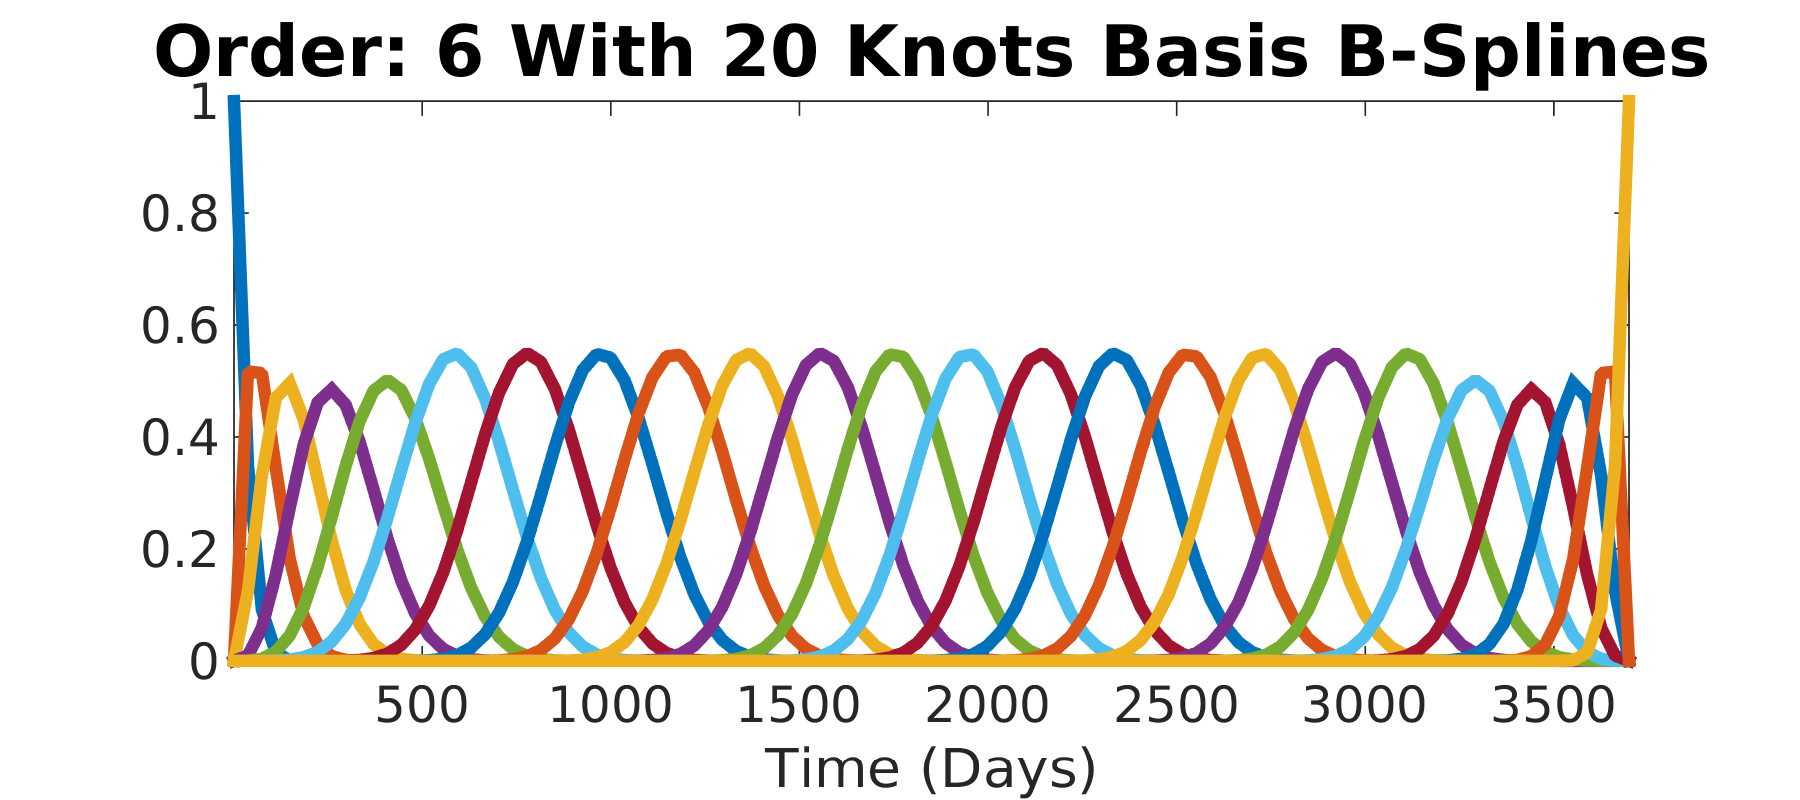

In [5]:
%plot inline -s 1800,800
StartTime = min(HistoricalStruct.time);
EndTime = max(HistoricalStruct.time);
norder = HistoricalStruct.spline(1);
nknots = HistoricalStruct.spline(2);
nbasis = nknots+norder-2;
emptyBasis = create_bspline_basis([StartTime EndTime], nbasis, norder);

NumResponses = size(Data,3); predPCA = cell(NumResponses,1);

        h = figure;
        hBasis = plot(emptyBasis);
        set(hBasis,'LineWidth',6);
        title([ 'Order: ' num2str(norder) ' With ' ...
            num2str(nknots) ' Knots Basis B-Splines'],'FontSize',34)
        xlabel('Time (Days)');
        axis tight;
        set(gcf,'color','w');
        
        set(h, 'Units', 'normalized', 'Position', [0,0,0.75,0.75]);
        set(gcf,'color','w');
        set(gca,'FontSize',FontSize);

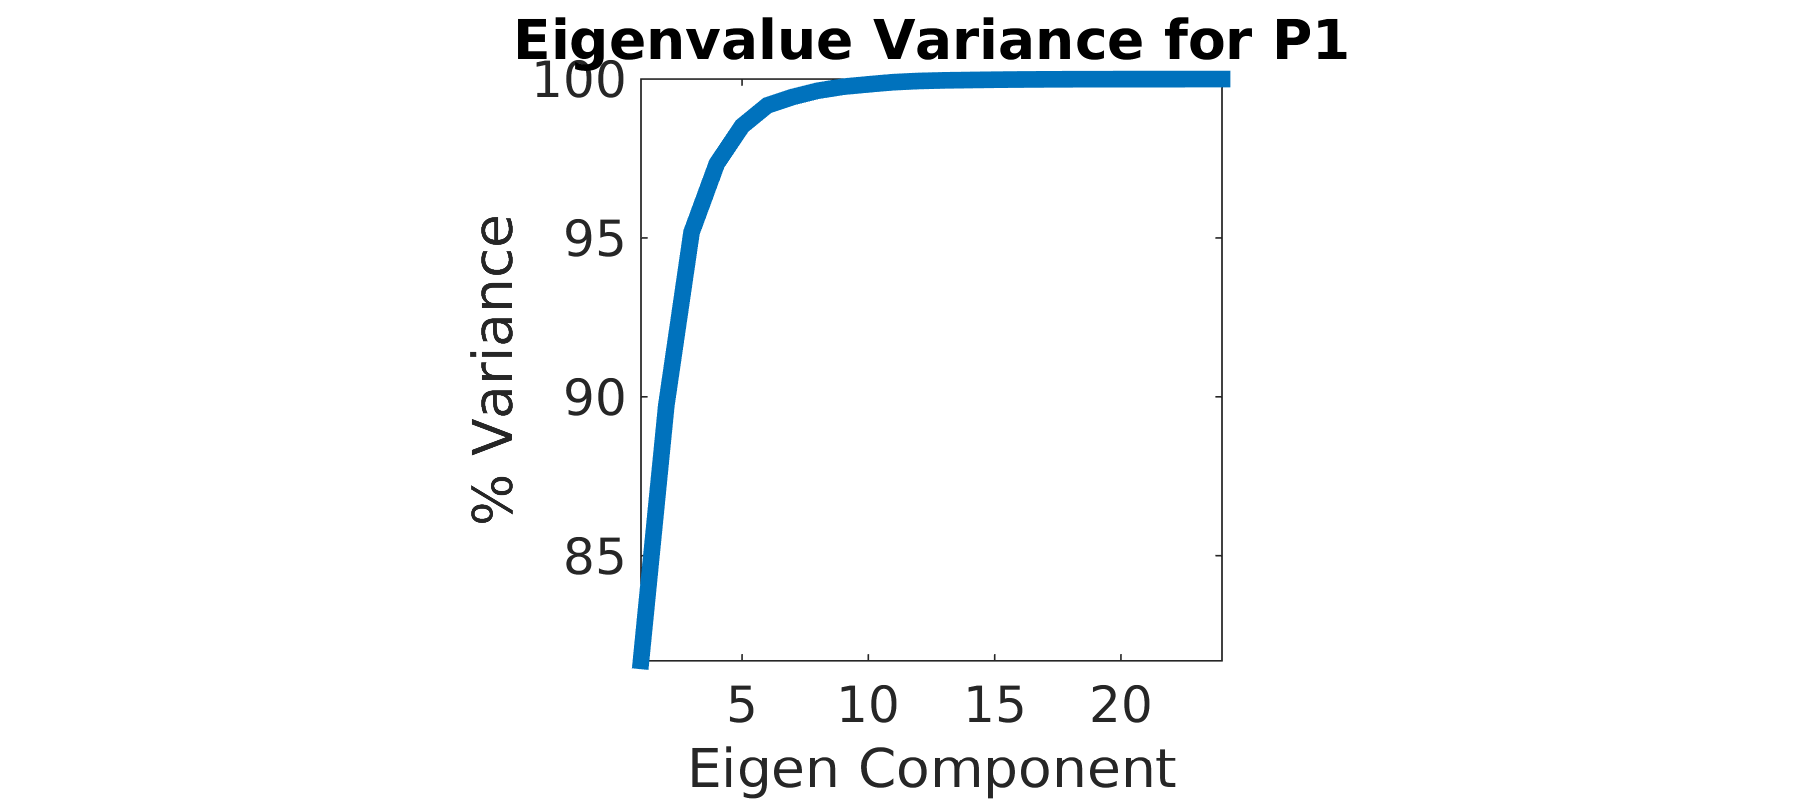

In [6]:
CurrentResponse = HistoricalStruct.data(:,:,1)';
    
predFd=data2fd(CurrentResponse,HistoricalStruct.time,emptyBasis,{'Time';'Model';HistoricalStruct.name});
predPCA{1} = pca_fd(predFd, nbasis);

%plot inline -s 800,800
hEigen=figure;
plot(cumsum(predPCA{1}.varprop)*100,'LineWidth',8); axis tight;
xlabel('Eigen Component');
ylabel('% Variance');
title(['Eigenvalue Variance for ' HistoricalStruct.ObjNames{1}]);
axis square; axis tight;
set(gca,'FontSize',FontSize);
set(gcf,'color','w');
set(hEigen, 'Units', 'normalized', 'Position', [0,0,0.75,0.75]);

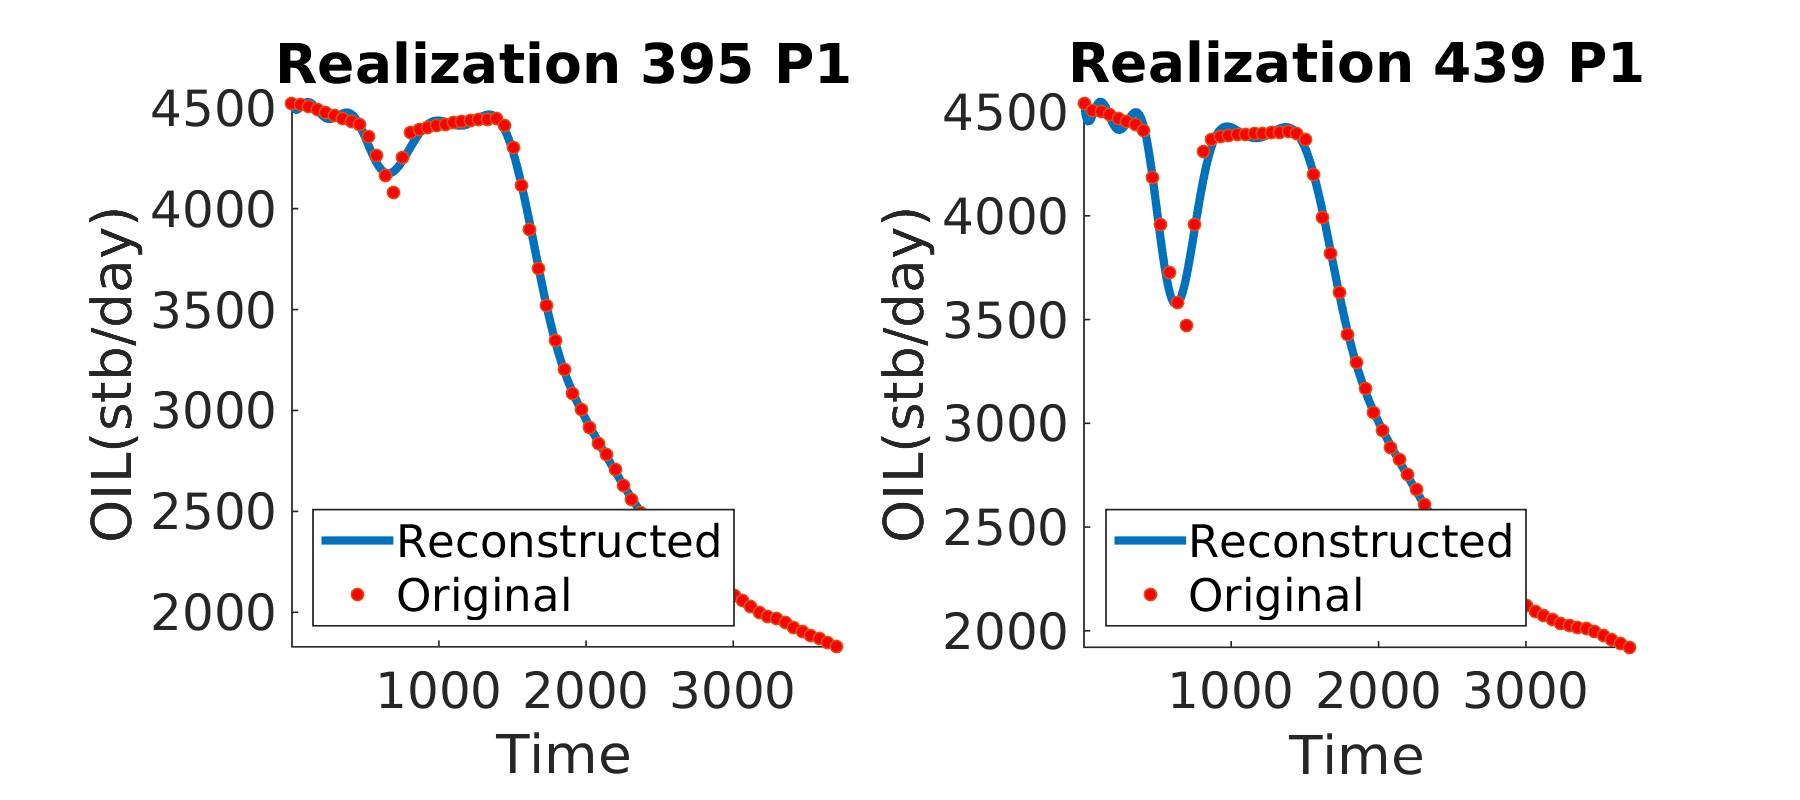

In [7]:
 %plot inline -s 1200,600
 % Plot two random fits
h2=figure;
i = randi([1 size(CurrentResponse,2)]);
subplot(1,2,1);
plotfit_fd(CurrentResponse(:,i),HistoricalStruct.time,predFd(i));
title(['Realization ' num2str(i) ' ' HistoricalStruct.ObjNames{1}]);
axis square; axis tight;
set(gca,'FontSize',FontSize);
       
        
i = randi([1 size(CurrentResponse,2)]);
subplot(1,2,2);
plotfit_fd(CurrentResponse(:,i),HistoricalStruct.time,predFd(i));
title(['Realization ' num2str(i) ' ' HistoricalStruct.ObjNames{1}]);
set(gcf,'color','w');
set(gca,'FontSize',FontSize);
axis square; axis tight;
set(h2, 'Units', 'normalized', 'Position', [0,0,0.75,0.75]);

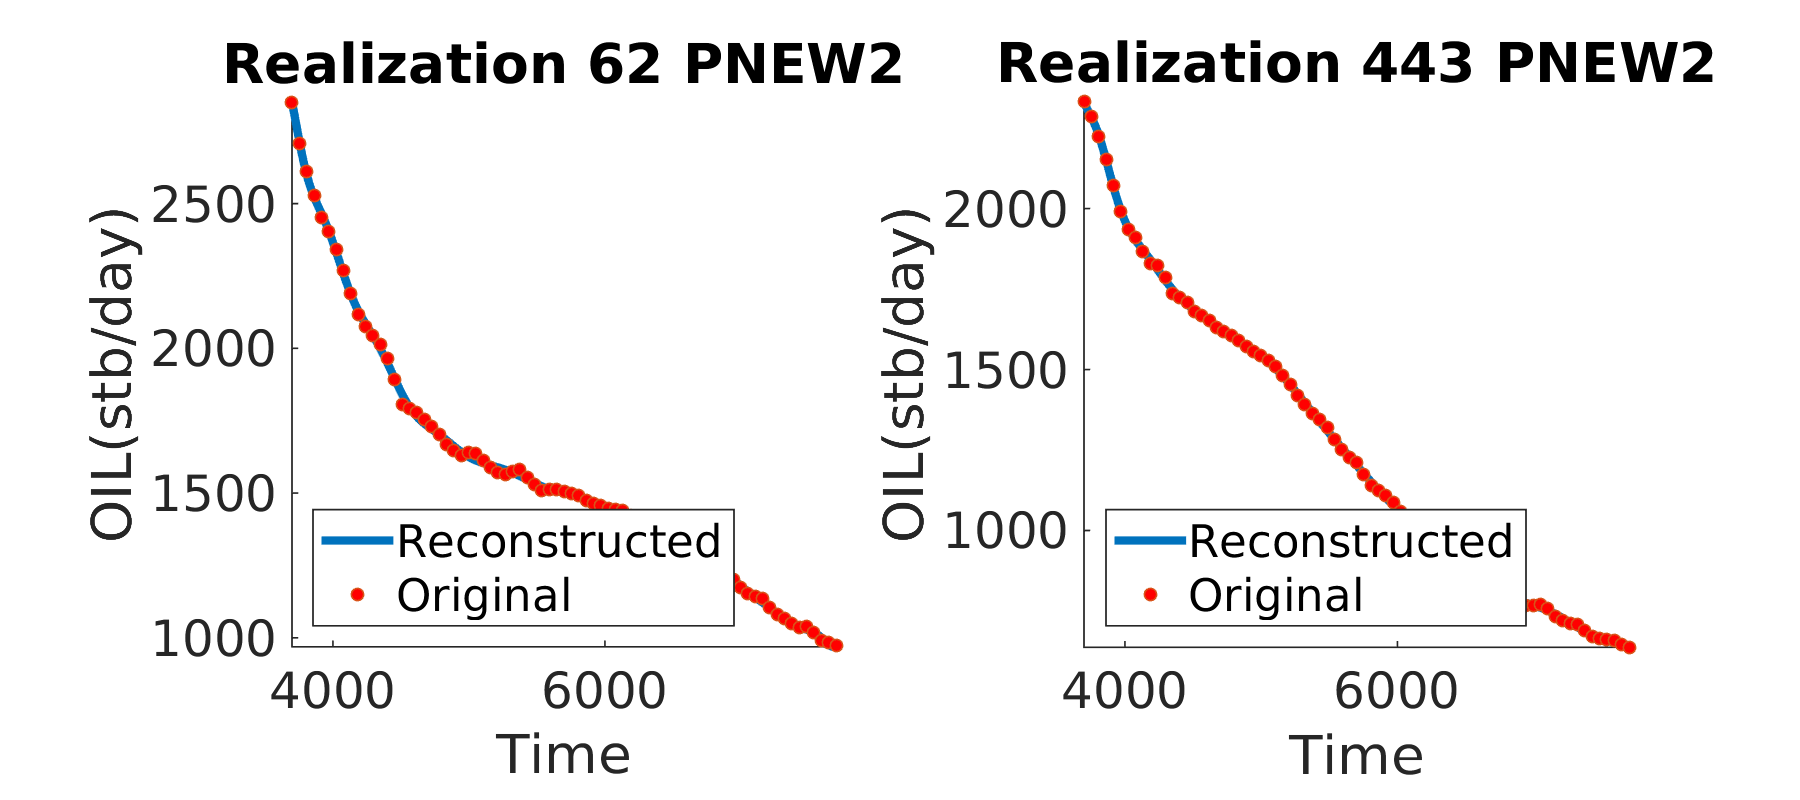

[Warning: Function isrow has the same name as a MATLAB builtin. We suggest you
rename the function to avoid a potential name conflict.] 
[> In path (line 109)
  In addpath (line 86)
  In ComputeHarmonicScores (line 34)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Function isrow has the same name as a MATLAB builtin. We suggest you
rename the function to avoid a potential name conflict.] 
[> In path (line 109)
  In addpath (line 86)
  In ComputeHarmonicScores (line 34)
  In pymat_eval (line 31)
  In matlabserver (line 24)]


In [8]:
histPCA = ComputeHarmonicScores(HistoricalStruct,0);

ForecastStruct.time = linspace(HistoricalStruct.time(end),...
    HistoricalStruct.time(end)+4000,length(ForecastStruct.time));
ForecastStruct.spline = [6 20];
predPCA = ComputeHarmonicScores(ForecastStruct,3);

In [9]:
Responses_Historical = HistoricalStruct.data;
NumHistoricalResponses = size(Responses_Historical,3);

AvailableRealizations = setdiff(1:size(Responses_Historical,1),...
    TruthRealization);

In [10]:
MinEigenValues = 2;
EigenTolerance = 0.99;

% Get number of required harmonics required for forecasts
nHarmPred = GetNumHarmonics(predPCA{1}, MinEigenValues,EigenTolerance);

% Get number of required harmonics required for forecasts
nHarmHist = 0;
for i = 1:NumHistoricalResponses
    responseNumHarms = GetNumHarmonics(histPCA{i},...
        MinEigenValues,EigenTolerance);
    nHarmHist = max(nHarmHist,responseNumHarms);
end

% Generate matrix of forecast harmonic scores
harmscrpred=predPCA{1}.harmscr;
Hf = harmscrpred(AvailableRealizations,1:nHarmPred);

% Generate matrix of historical harmonic scores
Df = zeros(length(AvailableRealizations),nHarmHist*NumHistoricalResponses);
dobs_f = zeros(1,nHarmHist*NumHistoricalResponses);

% Iterate over each historical response (ex: P1, P2)
for i = 1:NumHistoricalResponses
    harmscrhist=histPCA{i}.harmscr;
    
    % Need to re-arrange harmonic scores into Df such that the first
    % eigenvalues are placed in first
    for j = 1:nHarmHist
        Df(:,(i-1)*nHarmHist + j) = harmscrhist(AvailableRealizations,j);
        dobs_f(:,(i-1)*nHarmHist + j) = harmscrhist(TruthRealization,j);
    end
end

% Run PCA On Df
% Poor naming choice by FDA package... we need to remove it from the path
% in order to run PCA
rmpath('../../thirdparty/fda_matlab');

DfStar = [Df; dobs_f];
[~,score,~] = pca(DfStar);

% Project dobs_f onto PCA basis
dobs_fpca = score(end,:);
score(end,:) = [];

% Perform CCA
Df = score;

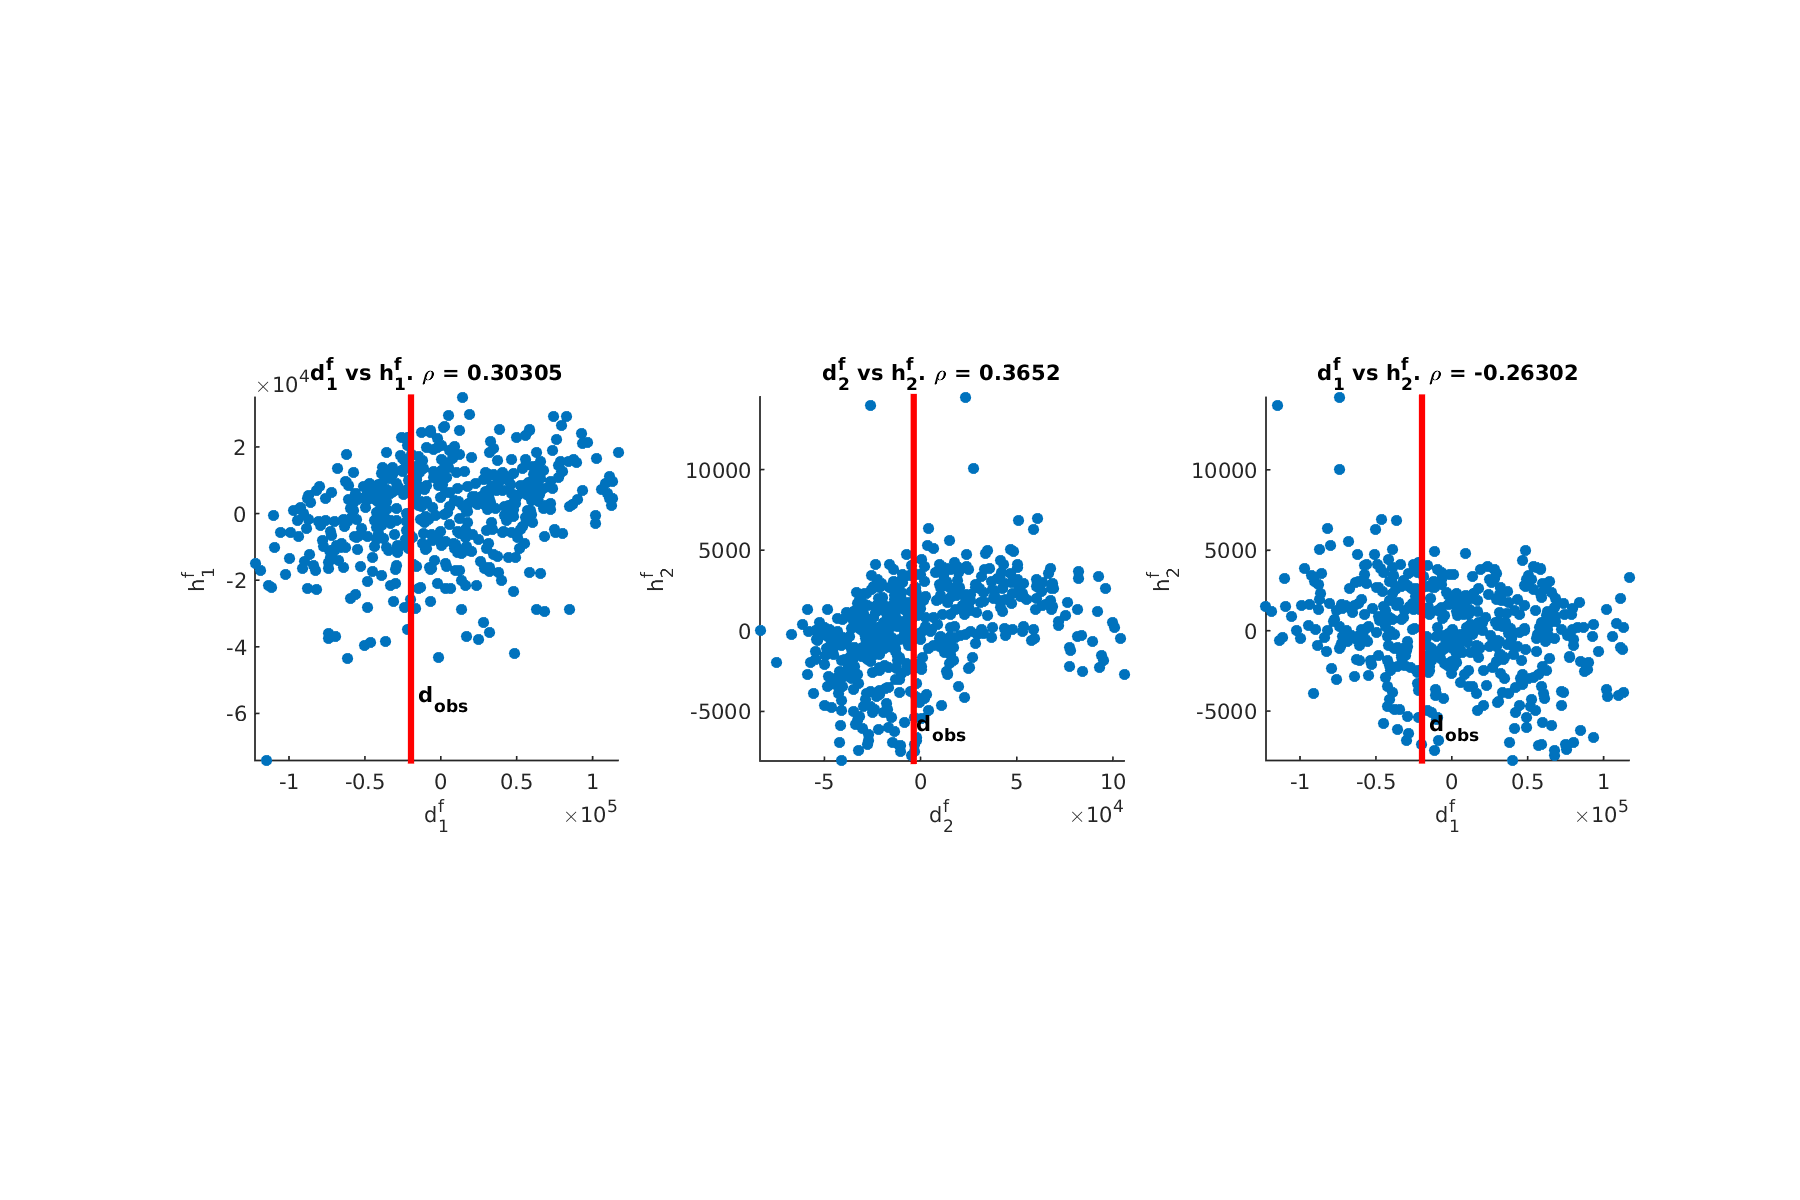

In [14]:
%plot inline -s 1800,1200
PlotLowDimModels(Df,Hf,dobs_fpca,'f',10);

In [16]:
[A, B, ~, Dc,Hc] = canoncorr(score,Hf);

% Project dobs_f into canonical space
dobs_c=(dobs_fpca-mean(score))*A;

% Apply an outlier detection
%[Dc,Hc] = LSOutlierDetection(Dc,Hc,OutlierPercentile);

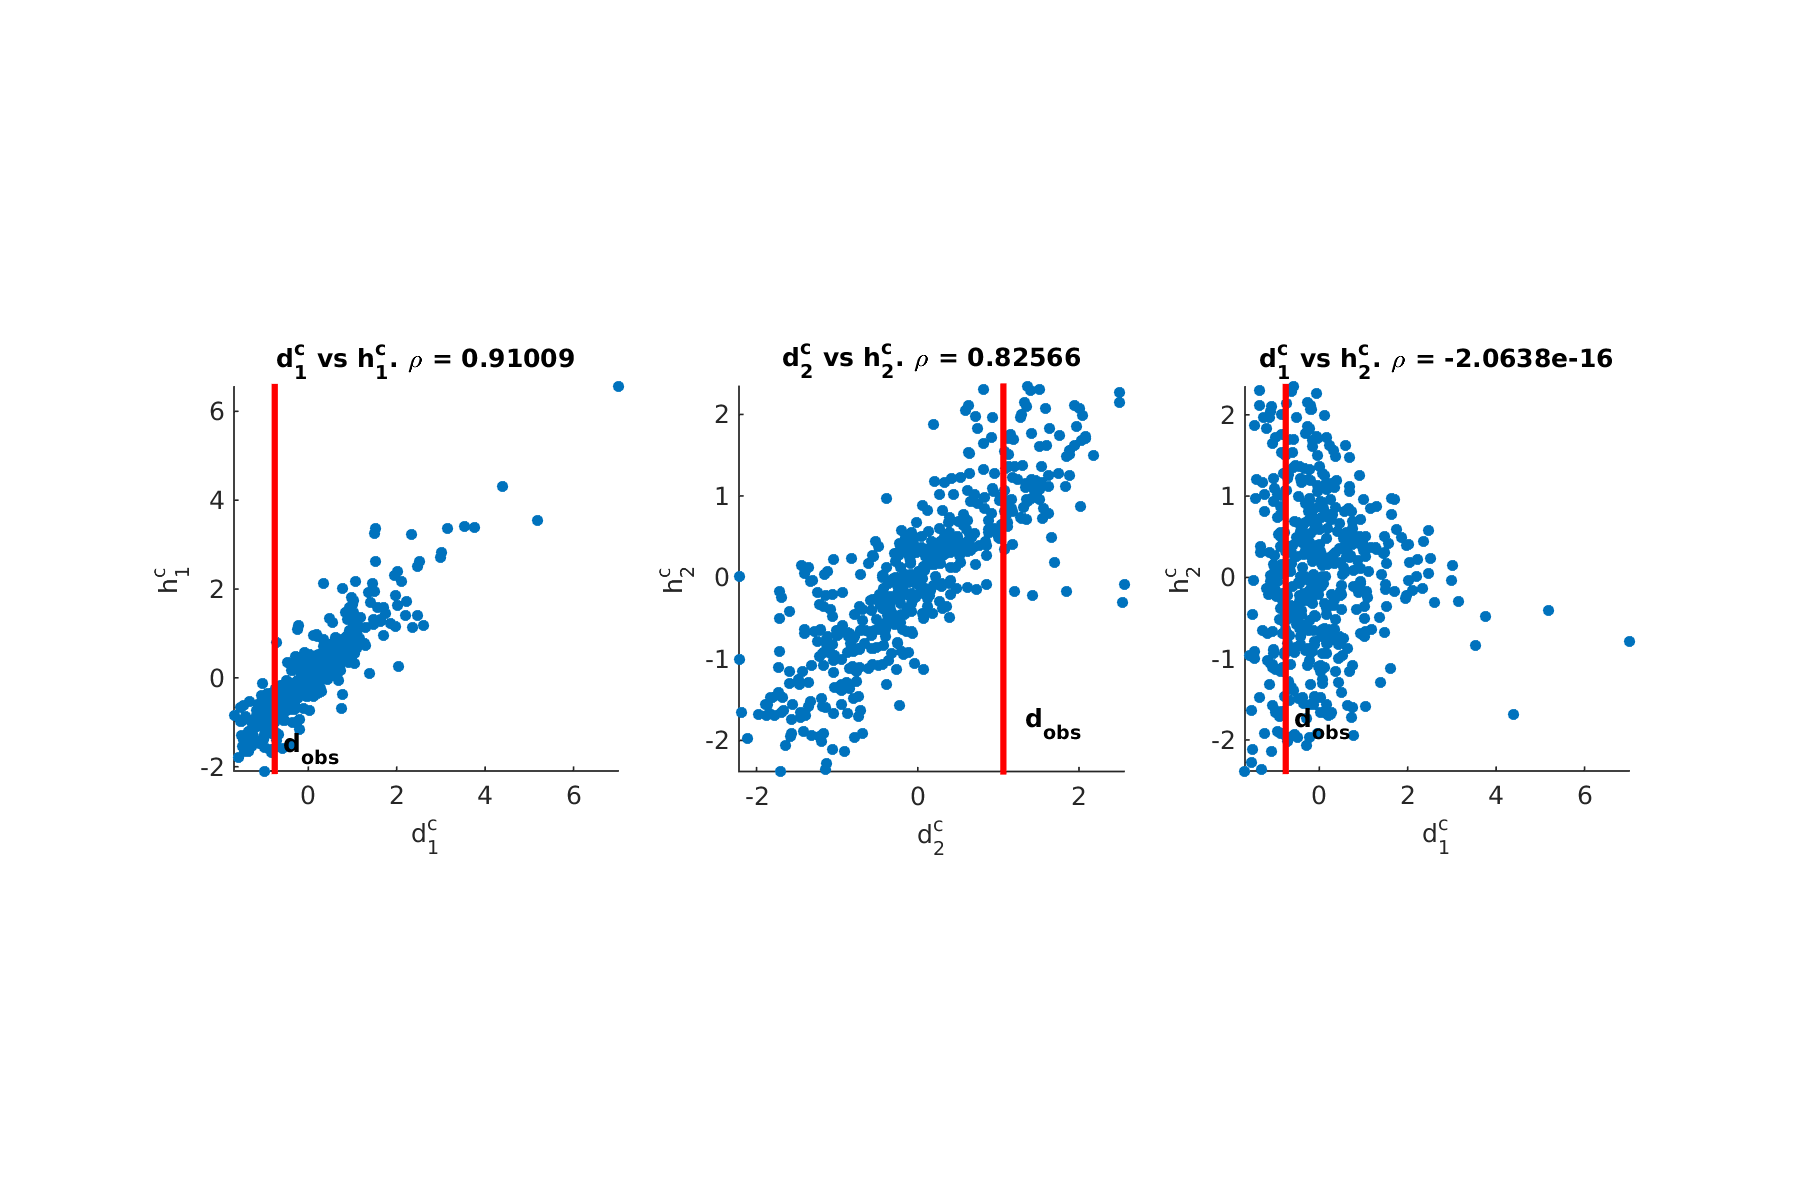

In [18]:
    PlotLowDimModels(Dc,Hc,dobs_c,'c',12);

In [19]:
Hc_gauss = NormalScoreTransform(Hc,0);
C_H = cov(Hc_gauss);
H_CG_Mean = mean(Hc_gauss)';

% Find best linear bit between Dc and Hc_gauss
G = Dc'/Hc_gauss';
DDiff= Dc'-G*Hc_gauss';
C_T = DDiff*DDiff'/length(Dc);

% Perform Gaussian Regression
mu_posterior = H_CG_Mean + C_H*G'*pinv(G*C_H*G' + C_T)*(dobs_c'-G*H_CG_Mean);
C_posterior = inv(G'*pinv(C_T)*G + inv(C_H));


In [21]:
addpath('../../thirdparty/fda_matlab');
ReferenceForecastFirstStep = ForecastStruct.data(TruthRealization,1);
NumPosteriorSamples = 100;

% The conditioning on mu_posterior, C_posterior against D_obs is not exact
% as this is done in the canonical space and not our original time-series
% space, hence we perform rejection sampling on the posterior sampled time
% series against the last observed historical data, as these two values
% should be the same. RJTolerance sets the maximum allowed deviation
% between the two (as a percentage)
RJTolerance = 1;

% Curve validity determines if we allow upwards or downwards trending
% curves
%CurveValidity = -1;  % Use for cumulative (must be monotonically increasing)
%CurveValidity = 1;  % Use for declines (must be monotonically decreasing)
CurveValidity = 0;  % Use when either is fine

% Generate posterior samples
[SampledPosteriorRealizations,~,Hf_post]= SampleCanonicalPosterior(...
    mu_posterior,C_posterior,NumPosteriorSamples,Hc,B,Hf,...
        ForecastStruct.time,predPCA,ReferenceForecastFirstStep,RJTolerance,1);

[Warning: Name is nonexistent or not a directory: ../thirdparty/fda_matlab] 
[> In path (line 109)
  In addpath (line 86)
  In SampleCanonicalPosterior (line 13)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Name is nonexistent or not a directory: util] 
[> In path (line 109)
  In addpath (line 86)
  In SampleCanonicalPosterior (line 14)
  In pymat_eval (line 31)
  In matlabserver (line 24)]


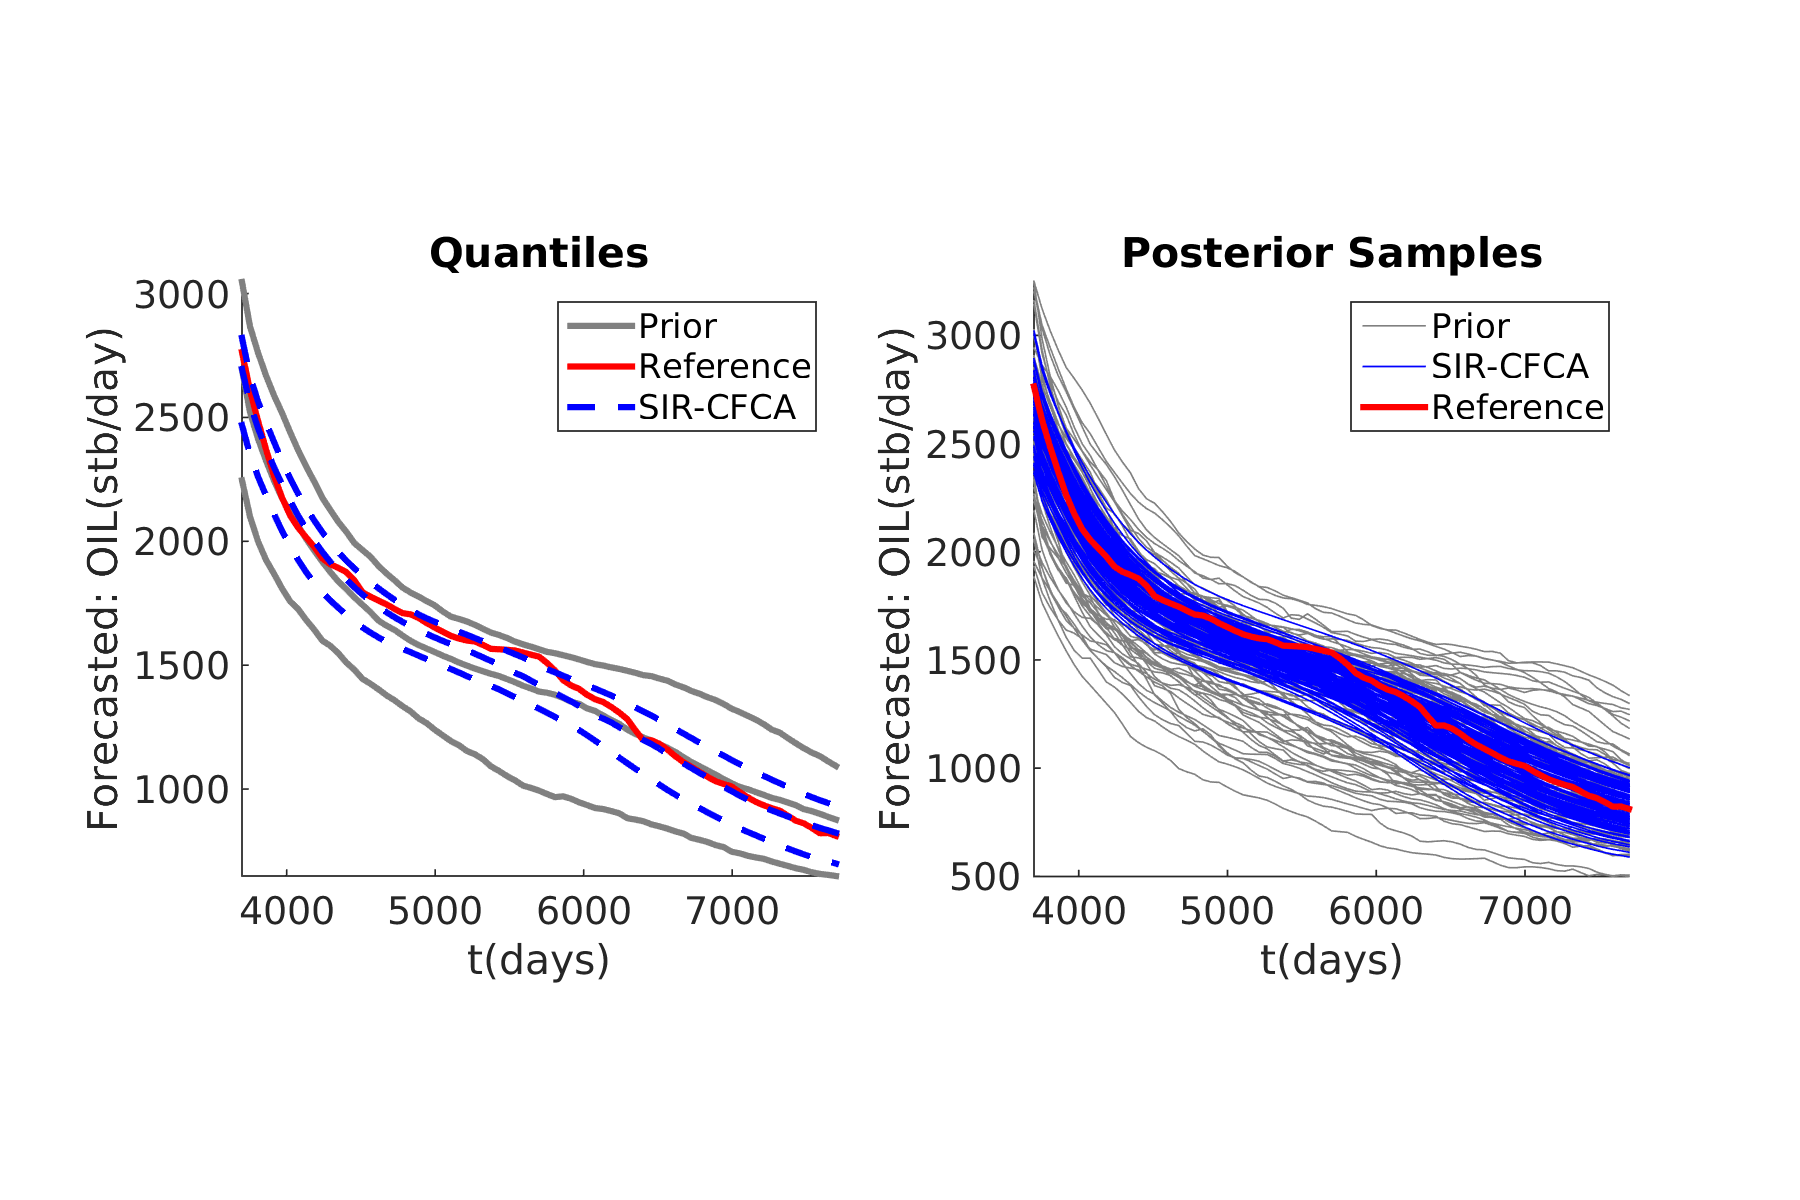

In [22]:
[PriorQuantiles, PosteriorQuantiles] = ComputeQuantiles(...
    ForecastStruct.data, SampledPosteriorRealizations);

% Plot sampled responses and quantiles
PlotPosteriorSamplesAndQuantiles(ForecastStruct,TruthRealization, ...
    SampledPosteriorRealizations,PriorQuantiles,PosteriorQuantiles);
